## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

In [2]:
jet = cv2.imread("jet.bmp")

In [3]:
def histFromImg(img):
        return cv2.calcHist([img], [0], None, [256], [0, 256])

def cumHistFromImg(img):
    return histFromImg(img).cumsum()

In [4]:
def readGrayImg(name):
    return plt.imread(name, cv2.IMREAD_GRAYSCALE)

In [5]:
def plotInLine(images, if_gray):
    images = images[0]
    cols = len(images)

    f, grid = plt.subplots(1, cols)
    f.set_size_inches(8, 4)
    f.tight_layout()

    for i, img in enumerate(images):
        if img.shape[1] == 1:
            grid[i].plot(img)
        else:
            if if_gray:
                grid[i].imshow(img, cmap='gray')
            else:
                grid[i].imshow(img)

In [6]:
def plotter(images, if_gray):
    rows = len(images)
    cols = max(map(len, images))

    if rows == 1:
        plotInLine(images, if_gray)
        return

    f, grid = plt.subplots(rows, cols)
    f.set_size_inches(7, 7)
    f.tight_layout()

    for i, row in enumerate(images):
        for j, img in enumerate(row):
            try:
                # this will cause to imshow img and plot vector
                if img.shape[1] == 1:
                    grid[i, j].plot(img)
                else:
                    if if_gray:
                        grid[i, j].imshow(img, cmap='gray')
                    else:
                        grid[i, j].imshow(img)
            except:
                grid[i, j].plot(img)

In [7]:
def bbheq(im):
    mean = round(np.mean(im))
    hist = histFromImg(im)

    h1 = hist[:mean]
    h2 = hist[mean:]

    h1cum = h1.cumsum()
    h2cum = h2.cumsum()

    h1cum = h1cum / max(h1cum)
    h2cum = h2cum / max(h2cum)

    h1cum = mean * h1cum
    h2cum = mean + (255 - mean) * h2cum

    lutFun = np.concatenate([h1cum, h2cum])

    Lut = cv2.LUT(jet, lutFun.astype('uint8'))
    StLut = cv2.LUT(jet, cumHistFromImg(im) / max(cumHistFromImg(im)) * 255).astype('uint8')

    plotter([[im, Lut, StLut],
         [histFromImg(im), histFromImg(Lut), histFromImg(StLut)],
         [cumHistFromImg(im), cumHistFromImg(Lut), cumHistFromImg(StLut)]], True)

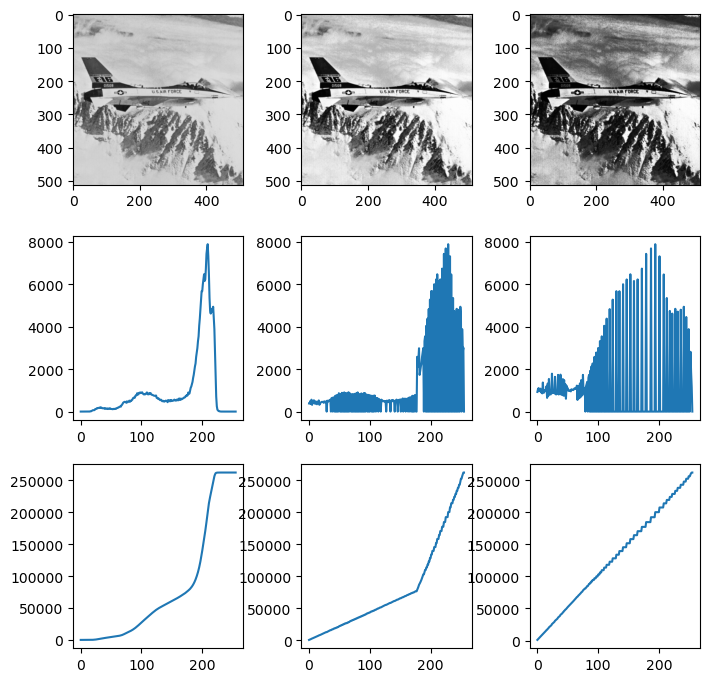

In [8]:
bbheq(jet)